In [1]:
import torch
import pandas as pd
import numpy as np
from models.resnetv2 import ResNet50, ResNet101
from torchvision import datasets, transforms
from PIL import Image
import torch.utils.data as data
from melanoma.melanoma_loader import Melanoma_loader
import matplotlib.pyplot as plt

# UTILS

In [2]:
from utils import stacked_img, iterate_class

# END UTILS

In [3]:
# melanoma model
# !wget -O model_melanoma https://www.dropbox.com/s/5gfs44hf282l22r/ckpt_epoch_18.pth?dl=0

In [4]:
path_to_model = 'model_melanoma'

In [5]:
model = ResNet50(out_features = 2, freeze = True, in_channels = 3)
checkpoint1 = torch.load(path_to_model, map_location='cpu')
msg1 = model.load_state_dict(checkpoint1['model'], strict=False)
msg1

<All keys matched successfully>

In [6]:
dataset = Melanoma_loader(root = "data/train/train", ann_path = "melanoma/data/test_set.csv", 
                          transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256, 256)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))

In [7]:
generator = iterate_class(dataset)

model = model.eval()

In [8]:
test_tensor, path = next(generator)

## LRP

In [9]:
from zennit.composites import EpsilonPlusFlat
from zennit.torchvision import ResNetCanonizer
from zennit.attribution import Gradient

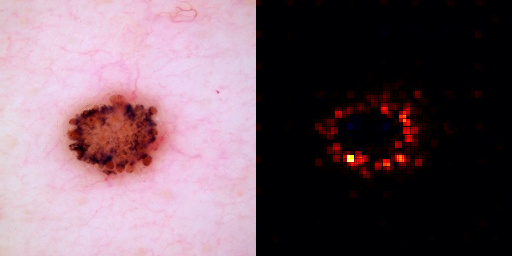

In [10]:
# use the ResNet-specific canonizer
canonizer = ResNetCanonizer()

# create a composite, specifying the canonizers
composite = EpsilonPlusFlat(canonizers=[canonizer])

# target = torch.eye(2)[[img[1]]] * out[0, 1]
target = torch.eye(2)[[1]]
# https://github.com/chr5tphr/zennit/blob/master/share/example/feed_forward.py#L149

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(test_tensor, target)
    
from zennit.image import imgify
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')
new_img = stacked_img(path, img)
# show the image
display(new_img)

In [11]:
model

ResNet50(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

LRP explained: https://iphome.hhi.de/samek/pdf/MonXAI19.pdf

# CRP

In [12]:
from HackedZennit import get_canonizer
from crp.attribution import CondAttribution
attribution = CondAttribution(model)

In [19]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model.eval()


sample, path = next(generator)

True


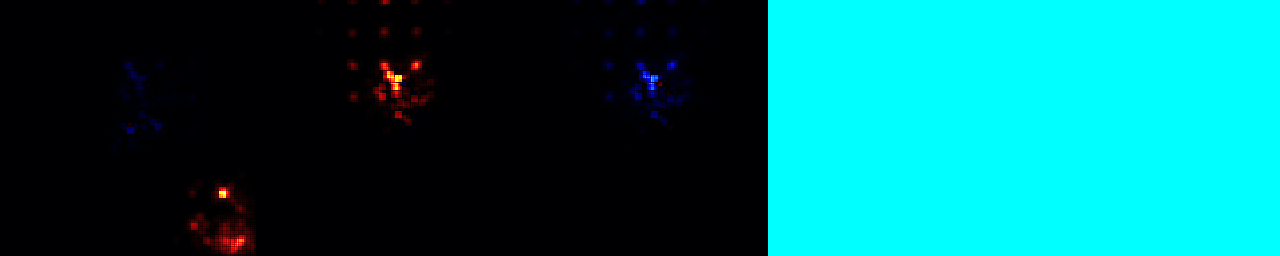

In [20]:
from crp.helper import get_layer_names
from crp.image import imgify

concept_ids = [0, 1, 10, 15, 32] # those are no of channels which we look at (used to define conditions)
conditions = [{'backbone.layer4.2.conv3': [ids], 'y': [1]} for ids in concept_ids]
# MUST ALWAYS HAVE LINE LIKE ONE BELOW - HACK
composite = EpsilonPlusFlat(canonizers=get_canonizer(conditions))
sample.requires_grad = True # This is not enough if you have multiple conditions 
# - in crp/attribution.py:CondAttribution.__call__ they duplicate data which removes grad requirement from copies
# WORKAROUND: in the __call__ function mentioned above add data.requires_grad = True before self.check_arguments
# or never pass a list of conditions
heatmaps, act, rel, _ = attribution(sample, conditions, composite)

img = imgify(heatmaps, symmetric=True, cmap='coldnhot', grid=(1, len(heatmaps)))
display(img)

Those all light blue images are 0 images - these channels have 0 relevance under current parameters.

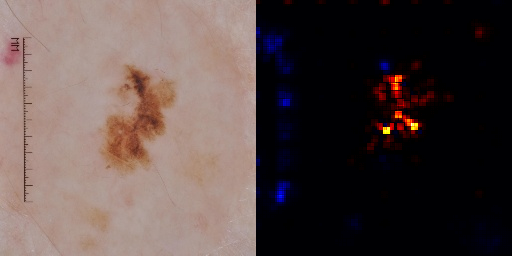

In [22]:
conditions = [{'y': [1]}]
composite = EpsilonPlusFlat(canonizers=get_canonizer(conditions))
sample.requires_grad = True
heatmaps, act, rel, _ = attribution(sample, conditions, composite)

img = imgify(heatmaps, symmetric=True, cmap='coldnhot', grid=(1, len(heatmaps)))
                                                       
new_img = stacked_img(path, img)

display(new_img)